# Machine Learning Modeling

In [1]:
import pandas as pd
import sklearn
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import XGBRFRegressor
from lightgbm import LGBMRegressor

In [2]:
prices_df = pd.read_csv('cleaned_dataset.csv')
prices_df.sample(3)

,loc1,loc2,para1,dow,para2,para3,para4,price
3879,4,47.0,1,1,423,3370.0,2.8,57.72
1446,8,85.0,5,4,1407,10000.0,13.6,2200.00
1633,4,45.0,1,2,276,1000.0,1.5,150.00


In [3]:
# spliting the data for training and testing

X = prices_df[['loc1', 'loc2', 'para1', 'dow', 'para2', 'para3', 'para4']]
y = prices_df['price']

X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8494, 7)
y_train shape: (1499, 7)
X_test shape: (8494,)
y_test shape: (1499,)


In [4]:
model_results = []

def calculate_r2_score(true_values, preds):
    r2_score_val = r2_score(true_values, preds)
    return r2_score_val

def train_model(model_type):
    model = model_type
    model.fit(X_train, X_test)
    
    #predicting the prices on both train and test data
    train_preds = model.predict(X_train)
    test_preds = model.predict(y_train)
    
    #calculating the r2-score (Evaluation)
    train_r2 = calculate_r2_score(X_test, train_preds)
    test_r2 = calculate_r2_score(y_test, test_preds)
    
    #Saving the model results into a dictionary
    result_dict = {
        'model_name': model_type,
        'test_r2_score': test_r2
    }
    model_results.append(result_dict)
    
    #printing the r2-scores
    print(f"R2-score on the training set for {model_type} is {train_r2:.4f}")
    print(f"R2-score on the test set for {model_type} is {test_r2:.4f}")

In [5]:
from sklearn.linear_model import Ridge
train_model(Ridge())

R2-score on the training set for Ridge() is 0.5554
R2-score on the test set for Ridge() is 0.5880


In [6]:
from sklearn.tree import DecisionTreeRegressor
train_model(DecisionTreeRegressor())

R2-score on the training set for DecisionTreeRegressor() is 0.9999
R2-score on the test set for DecisionTreeRegressor() is 0.5139


In [7]:
from sklearn.ensemble import RandomForestRegressor
train_model(RandomForestRegressor())

R2-score on the training set for RandomForestRegressor() is 0.9572
R2-score on the test set for RandomForestRegressor() is 0.7224


In [8]:
train_model(XGBRFRegressor())

[08:11:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2-score on the training set for XGBRFRegressor() is 0.6085
R2-score on the test set for XGBRFRegressor() is 0.6168


In [9]:
train_model(LGBMRegressor())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 8494, number of used features: 7
[LightGBM] [Info] Start training from score 432.145333
R2-score on the training set for LGBMRegressor() is 0.8022
R2-score on the test set for LGBMRegressor() is 0.7159


In [10]:
model_results

[{'model_name': Ridge(), 'test_r2_score': 0.5879624834809501},
 {'model_name': DecisionTreeRegressor(), 'test_r2_score': 0.5138615200084724},
 {'model_name': RandomForestRegressor(), 'test_r2_score': 0.7224021535682885},
 {'model_name': XGBRFRegressor(), 'test_r2_score': 0.6167891056424547},
 {'model_name': LGBMRegressor(), 'test_r2_score': 0.7158531789259266}]

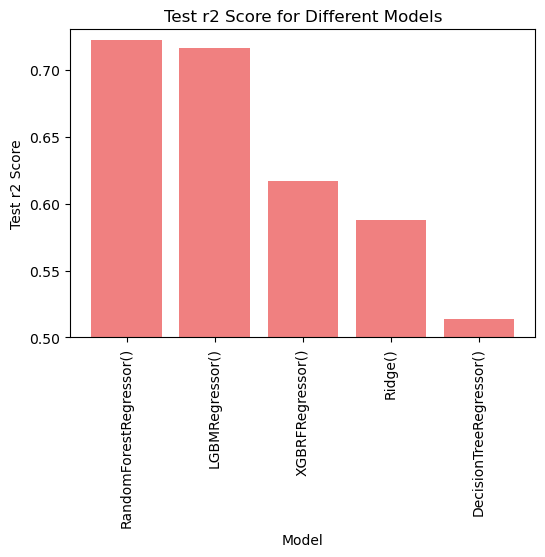

In [11]:
import matplotlib.pyplot as plt

#ploting the models and their micro-f1-scores on validation sets 
model_results.sort(key=lambda x: x['test_r2_score'], reverse=True)
model_names = [val['model_name'] for val in model_results]
f1_scores = [val['test_r2_score'] for val in model_results]
model_names = list(map(str, model_names))

plt.figure(figsize=(6,4))
plt.bar(model_names, f1_scores, color='lightcoral')
plt.ylim(0.5, 0.73)
plt.xlabel('Model')
plt.ylabel('Test r2 Score')
plt.title('Test r2 Score for Different Models')
plt.xticks(rotation=90);

The LightXGM model genralized more on both trainand test data compared to RandomForest. Auto-tuned LightGBM model results are decent compared to when done manually so we are not doing them again :)

## Deep Learning

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)

#Defining the Neural Network
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = NeuralNet(input_size=X_train.shape[1])

# Defining the loss and optimizers 
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Converting the data into tensors
x_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
x_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Train the model
history = {'loss':[], 'test_loss':[]}

for epoch in range(30):
    model.train()
    outputs = model(x_train_tensor)
    loss = criterion(outputs, x_test_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    history['loss'].append(loss.item())
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(y_train_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)  # Compute test loss
        history['test_loss'].append(test_loss.item())  # Store test loss
        
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}: The loss is {loss.item()} and the test_loss is {test_loss.item()}")

Epoch 5: The loss is 648946.6875 and the test_loss is 580828.5
Epoch 10: The loss is 287307.1875 and the test_loss is 263176.53125
Epoch 15: The loss is 151985.546875 and the test_loss is 161499.53125
Epoch 20: The loss is 153981.234375 and the test_loss is 175636.734375
Epoch 25: The loss is 179274.34375 and the test_loss is 195985.34375
Epoch 30: The loss is 172597.4375 and the test_loss is 183681.6875


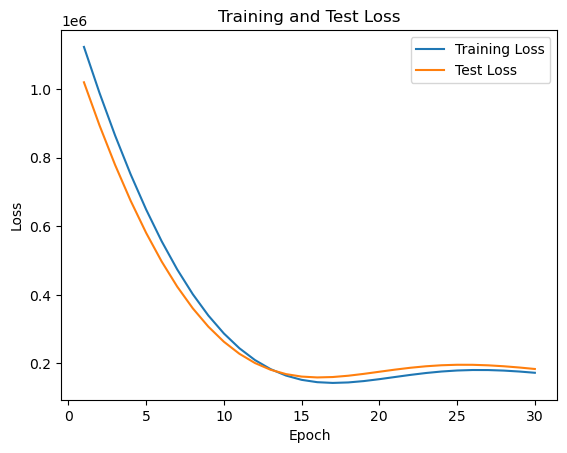

In [17]:
import matplotlib.pyplot as plt

# Plot the training and test loss
plt.plot(range(1, 31), history['loss'], label='Training Loss')
plt.plot(range(1, 31), history['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()